In [0]:
# %tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-01-01 23:52:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-01-01 23:52:37 (145 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



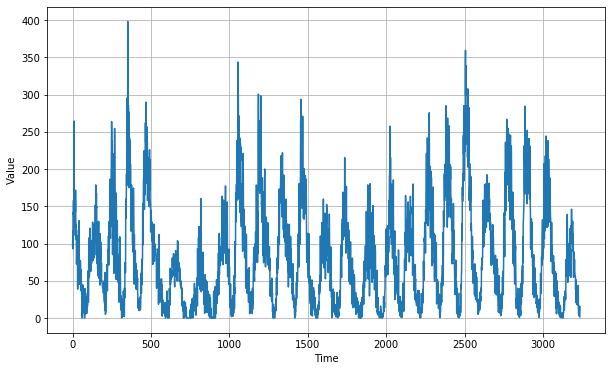

In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 299ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 1s 44ms/step - loss: 78.2509 - mae: 78.5897
Epoch 3/100
12/12 [==============================] - 1s 43ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 42ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 45ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 44ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 1s 43ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 1s 43ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 1s 43ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12 [====

[1e-08, 0.0001, 0, 60]

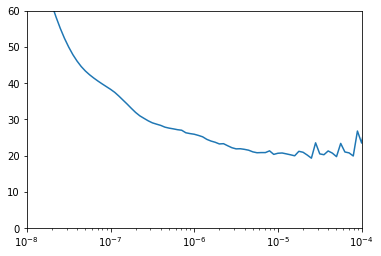

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 85ms/step - loss: 37.8967 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 1s 21ms/step - loss: 24.0746 - mae: 24.6112
Epoch 3/500
30/30 [==============================] - 1s 21ms/step - loss: 22.0136 - mae: 22.5112
Epoch 4/500
30/30 [==============================] - 1s 22ms/step - loss: 19.8688 - mae: 20.3488
Epoch 5/500
30/30 [==============================] - 1s 21ms/step - loss: 19.5531 - mae: 20.0256
Epoch 6/500
30/30 [==============================] - 1s 21ms/step - loss: 19.1442 - mae: 19.6358
Epoch 7/500
30/30 [==============================] - 1s 22ms/step - loss: 18.6279 - mae: 19.1168
Epoch 8/500
30/30 [==============================] - 1s 22ms/step - loss: 18.3936 - mae: 18.9033
Epoch 9/500
30/30 [==============================] - 1s 21ms/step - loss: 18.2711 - mae: 18.7262
Epoch 10/500
30/30 [==============================] - 1s 20ms/step - loss: 18.1637 - mae: 18.6356
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

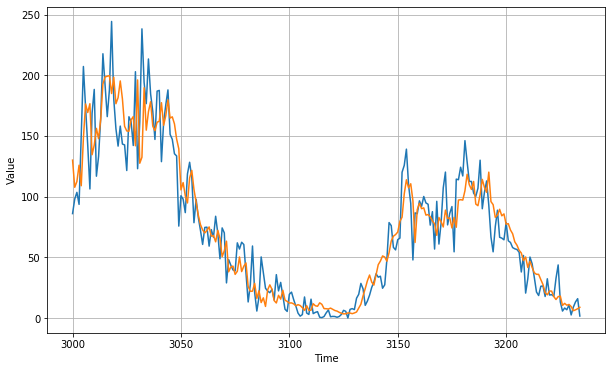

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([ 71.344025,  59.014828,  61.297287,  68.75934 ,  59.614826,
        83.66423 , 106.227974, 100.26619 , 106.41949 ,  74.218575,
        79.59887 ,  89.79538 ,  83.37063 ,  95.750206, 120.99051 ,
       126.51337 , 127.05312 , 127.572105, 113.7846  , 126.3309  ,
       106.41538 , 110.74825 , 123.38401 , 109.87604 ,  91.12613 ,
        88.17306 ,  88.03084 ,  95.30456 ,  97.47507 ,  79.16037 ,
       124.159134,  69.74676 ,  72.87385 , 118.05387 ,  88.68574 ,
       100.79465 , 107.82736 ,  91.19821 ,  88.33508 ,  93.73046 ,
        94.38016 , 107.14561 ,  91.74389 ,  98.107956, 109.17849 ,
        96.45962 ,  97.29677 ,  92.68359 ,  83.175766,  77.48027 ,
        58.03    ,  60.858734,  55.944157,  53.69202 ,  62.81568 ,
        66.2243  ,  58.18249 ,  53.905247,  50.8448  ,  49.230953,
        48.670677,  48.44632 ,  48.62936 ,  48.944996,  48.247787,
        48.291016,  48.099792,  48.63619 ,  48.14624 ,  49.24611 ,
        48.544308,  48.101967,  51.93423 ,  50.98717 ,  50.820

<Figure size 432x288 with 0 Axes>

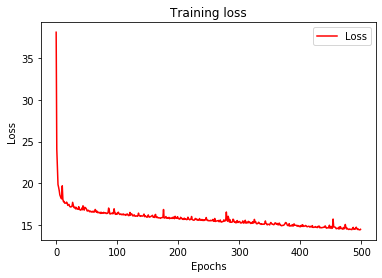

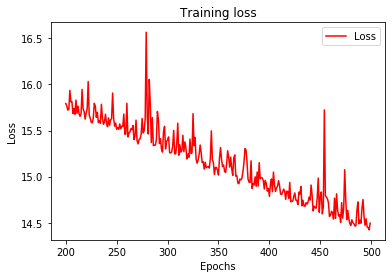

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
print(rnn_forecast)

[[130.04865  ]
 [107.67734  ]
 [112.45276  ]
 [125.86255  ]
 [108.94761  ]
 [148.10966  ]
 [176.30875  ]
 [169.2947   ]
 [176.53044  ]
 [134.49074  ]
 [142.49232  ]
 [156.20781  ]
 [147.71541  ]
 [163.79681  ]
 [192.77588  ]
 [198.60782  ]
 [199.1766   ]
 [199.72353  ]
 [184.92766  ]
 [198.41553  ]
 [176.5257   ]
 [181.48376  ]
 [195.31006  ]
 [180.49352  ]
 [157.93558  ]
 [154.08026  ]
 [153.89355  ]
 [163.24269  ]
 [165.93713  ]
 [141.85956  ]
 [196.12689  ]
 [127.48524  ]
 [132.42949  ]
 [189.63635  ]
 [154.75334  ]
 [169.9251   ]
 [178.14502  ]
 [158.02917  ]
 [154.29298  ]
 [161.27869  ]
 [162.09332  ]
 [177.3635   ]
 [158.73068  ]
 [166.69984  ]
 [179.69388  ]
 [164.6789   ]
 [165.71959  ]
 [159.9374   ]
 [147.45374  ]
 [139.37964  ]
 [105.52143  ]
 [111.54073  ]
 [100.7028   ]
 [ 94.766975 ]
 [115.41748  ]
 [121.58254  ]
 [105.862724 ]
 [ 95.37148  ]
 [ 84.79675  ]
 [ 76.91646  ]
 [ 72.54391  ]
 [ 70.06235  ]
 [ 72.11423  ]
 [ 75.02495  ]
 [ 67.36062  ]
 [ 67.95814  ]
 [ 62.7509